Done!--All training tasks tagged.

In the following (hidden) cells I create a dataframe to encode task tags and properties in a way that could possibly generalize to further tasks. The classification is far from perfect and depends largely on my ability to describe task resolution in a DSL-ish and transferrable way, so any help and corrections are greatly appreciated. All my gratitude to boliu0 for [making this bearable](https://www.kaggle.com/boliu0/visualizing-all-task-pairs-with-gridlines).

The dataframe can be imported from the outputs of this kernel. 

## Imports

In [4]:
import numpy as np
import pandas as pd

import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input, concatenate, Activation, BatchNormalization, Softmax, Conv2DTranspose
import tensorflow.keras.layers as layers
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import tensorflow.keras as keras
import os
import json
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
    
from pathlib import Path

data_path = Path('/kaggle/input/abstraction-and-reasoning-challenge/')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'

/kaggle/input
/kaggle/input/abstraction-and-reasoning-challenge
/kaggle/input/abstraction-and-reasoning-challenge/evaluation
/kaggle/input/abstraction-and-reasoning-challenge/test
/kaggle/input/abstraction-and-reasoning-challenge/training


## Plot func

In [5]:
def plot_one(task, ax, i,train_or_test,input_or_output):
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    
    input_matrix = task[train_or_test][i][input_or_output]
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
    ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
    ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(train_or_test + ' '+input_or_output)

def plot(img):
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=cmap, norm=norm)
    ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
    ax.set_yticks([x-0.5 for x in range(1+len(img))])
    ax.set_xticks([x-0.5 for x in range(1+len(img[0]))])     
    ax.set_xticklabels([])
    ax.set_yticklabels([])


def plot_task(task):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """    
    num_train = len(task['train'])
    fig, axs = plt.subplots(2, num_train, figsize=(3*num_train,3*2))
    for i in range(num_train):     
        plot_one(task, axs[0,i],i,'train','input')
        plot_one(task, axs[1,i],i,'train','output')        
    plt.tight_layout()
    plt.show()        
        
    num_test = len(task['test'])
    fig, axs = plt.subplots(2, num_test, figsize=(3*num_test,3*2))
    if num_test==1: 
        plot_one(task, axs[0],0,'test','input')
        plot_one(task, axs[1],0,'test','output')     
    else:
        for i in range(num_test):      
            plot_one(task, axs[0,i],i,'test','input')
            plot_one(task, axs[1,i],i,'test','output')  
    plt.tight_layout()
    plt.show() 

## Skills list

In [6]:
skill_series = pd.Series(
    [[] for name in sorted(os.listdir(training_path))],
    index = sorted(os.listdir(training_path))
)

# 0-5
skill_series['007bbfb7.json'] = ['image_repetition', 'fractal_repetition']
skill_series['00d62c1b.json'] = ['loop_filling']
skill_series['017c7c7b.json'] = ['recoloring', 'pattern_expansion', 'pattern_repetition', 'image_expansion']
skill_series['025d127b.json'] = ['pattern_modification']
skill_series['045e512c.json'] = ['pattern_expansion', 'direction_guessing']
skill_series['0520fde7.json'] = ['detect_wall', 'separate_images', 'pattern_intersection']

# 6-10
skill_series['05269061.json'] = ['image_filling', 'pattern_expansion', 'diagonals']
skill_series['05f2a901.json'] = ['pattern_moving', 'direction_guessing', 'bring_patterns_close']
skill_series['06df4c85.json'] = ['detect_grid', 'connect_the_dots', 'grid_coloring']
skill_series['08ed6ac7.json'] = ['measure_length', 'order_numbers', 'associate_colors_to_ranks', 'recoloring']
skill_series['09629e4f.json'] = ['detect_grid', 'separate_images', 'count_tiles', 'take_minimum', 'enlarge_image', 'create_grid', 'adapt_image_to_grid']

# 11-15
skill_series['0962bcdd.json'] = ['pattern_expansion']
skill_series['0a938d79.json'] = ['direction_guessing', 'draw_line_from_point', 'pattern_expansion']
skill_series['0b148d64.json'] = ['detect_grid', 'separate_images', 'find_the_intruder', 'crop']
skill_series['0ca9ddb6.json'] = ['pattern_expansion', 'associate_patterns_to_colors']
skill_series['0d3d703e.json'] = ['associate_colors_to_colors']

# 16-20
skill_series['0dfd9992.json'] = ['image_filling', 'pattern_expansion']
skill_series['0e206a2e.json'] = ['associate_patterns_to_patterns', 'pattern_repetition', 'pattern_rotation', 'pattern_reflection', 'pattern_juxtaposition']
skill_series['10fcaaa3.json'] = ['pattern_expansion', 'image_repetition']
skill_series['11852cab.json'] = ['pattern_expansion']
skill_series['1190e5a7.json'] = ['detect_grid', 'count_hor_lines', 'count_ver_lines', 'detect_background_color', 'color_guessing', 'create_image_from_info']

# 21-25
skill_series['137eaa0f.json'] = ['pattern_juxtaposition']
skill_series['150deff5.json'] = ['pattern_coloring', 'pattern_deconstruction', 'associate_colors_to_patterns']
skill_series['178fcbfb.json'] = ['direction_guessing', 'draw_line_from_point']
skill_series['1a07d186.json'] = ['bring_patterns_close', 'find_the_intruder']
skill_series['1b2d62fb.json'] = ['detect_wall', 'separate_images', 'pattern_intersection']

# 26-30
skill_series['1b60fb0c.json'] = ['pattern_deconstruction', 'pattern_rotation', 'pattern_expansion']
skill_series['1bfc4729.json'] = ['pattern_expansion']
skill_series['1c786137.json'] = ['detect_enclosure', 'crop']
skill_series['1caeab9d.json'] = ['pattern_moving', 'pattern_alignment']
skill_series['1cf80156.json'] = ['crop']

# 31-35
skill_series['1e0a9b12.json'] = ['pattern_moving', 'gravity']
skill_series['1e32b0e9.json'] = ['detect_grid', 'separate_images', 'image_repetition', 'pattern_completion']
skill_series['1f0c79e5.json'] = ['pattern_expansion', 'diagonals', 'direction_guessing']
skill_series['1f642eb9.json'] = ['image_within_image', 'projection_unto_rectangle']
skill_series['1f85a75f.json'] = ['crop', 'find_the_intruder']

# 36-40
skill_series['1f876c06.json'] = ['connect_the_dots', 'diagonals']
skill_series['1fad071e.json'] = ['count_patterns', 'associate_images_to_numbers']
skill_series['2013d3e2.json'] = ['pattern_deconstruction', 'crop']
skill_series['2204b7a8.json'] = ['proximity_guessing', 'recoloring']
skill_series['22168020.json'] = ['pattern_expansion']

# 41-45
skill_series['22233c11.json'] = ['pattern_expansion', 'size_guessing']
skill_series['2281f1f4.json'] = ['direction_guessing', 'draw_line_from_point', 'pattern_intersection']
skill_series['228f6490.json'] = ['pattern_moving', 'loop_filling', 'shape_guessing', 'x_marks_the_spot']
skill_series['22eb0ac0.json'] = ['connect_the_dots', 'color_matching']
skill_series['234bbc79.json'] = ['recoloring', 'bring_patterns_close', 'crop']

# 46-50
skill_series['23581191.json'] = ['draw_line_from_point', 'pattern_intersection']
skill_series['239be575.json'] = ['detect_connectedness', 'associate_images_to_bools']
skill_series['23b5c85d.json'] = ['measure_area', 'take_minimum', 'crop']
skill_series['253bf280.json'] = ['connect_the_dots', 'direction_guessing']
skill_series['25d487eb.json'] = ['draw_line_from_point', 'direction_guessing', 'color_guessing']

# 51-55
skill_series['25d8a9c8.json'] = ['detect_hor_lines', 'recoloring', 'remove_noise']
skill_series['25ff71a9.json'] = ['pattern_moving']
skill_series['264363fd.json'] = ['pattern_repetition', 'pattern_juxtaposition', 'draw_line_from_point']
skill_series['272f95fa.json'] = ['detect_grid', 'mimic_pattern', 'grid_coloring']
skill_series['27a28665.json'] = ['associate_colors_to_patterns', 'take_negative', 'associate_images_to_patterns']

# 56-60
skill_series['28bf18c6.json'] = ['crop', 'pattern_repetition']
skill_series['28e73c20.json'] = ['ex_nihilo', 'mimic_pattern']
skill_series['29623171.json'] = ['detect_grid', 'separate_images', 'count_tiles', 'take_maximum', 'grid_coloring']
skill_series['29c11459.json'] = ['draw_line_from_point', 'count_tiles']
skill_series['29ec7d0e.json'] = ['image_filling', 'pattern_expansion', 'detect_grid', 'pattern_repetition']

# 61-65
skill_series['2bcee788.json'] = ['pattern_reflection', 'direction_guessing', 'image_filling', 'background_filling']
skill_series['2bee17df.json'] = ['draw_line_from_border', 'count_tiles', 'take_maximum']
skill_series['2c608aff.json'] = ['draw_line_from_point', 'projection_unto_rectangle']
skill_series['2dc579da.json'] = ['detect_grid', 'find_the_intruder', 'crop']
skill_series['2dd70a9a.json'] = ['draw_line_from_point', 'direction_guessing', 'maze']

# 66-70
skill_series['2dee498d.json'] = ['detect_repetition', 'crop', 'divide_by_n']
skill_series['31aa019c.json'] = ['find_the_intruder', 'remove_noise', 'contouring']
skill_series['321b1fc6.json'] = ['pattern_repetition', 'pattern_juxtaposition']
skill_series['32597951.json'] = ['find_the_intruder', 'recoloring']
skill_series['3345333e.json'] = ['pattern_completion', 'pattern_reflection', 'remove_noise']

# 71-75
skill_series['3428a4f5.json'] = ['detect_wall', 'separate_images', 'pattern_differences']
skill_series['3618c87e.json'] = ['gravity']
skill_series['3631a71a.json'] = ['image_filling', 'pattern_expansion', 'pattern_rotation']
skill_series['363442ee.json'] = ['detect_wall', 'pattern_repetition', 'pattern_juxtaposition']
skill_series['36d67576.json'] = ['pattern_repetition', 'pattern_juxtaposition', 'pattern_reflection', 'pattern_rotation']

# 76-80
skill_series['36fdfd69.json'] = ['recoloring', 'rectangle_guessing']
skill_series['3906de3d.json'] = ['gravity']
skill_series['39a8645d.json'] = ['count_patterns', 'take_maximum', 'crop']
skill_series['39e1d7f9.json'] = ['detect_grid', 'pattern_repetition', 'grid_coloring']
skill_series['3aa6fb7a.json'] = ['pattern_completion', 'pattern_rotation']

# 81-85
skill_series['3ac3eb23.json'] = ['draw_pattern_from_point', 'pattern_repetition']
skill_series['3af2c5a8.json'] = ['image_repetition', 'image_reflection', 'image_rotation']
skill_series['3bd67248.json'] = ['draw_line_from_border', 'diagonals','pattern_repetition']
skill_series['3bdb4ada.json'] = ['recoloring','pattern_repetition', 'holes']
skill_series['3befdf3e.json'] = ['take_negative', 'pattern_expansion']

# 86-90
skill_series['3c9b0459.json'] = ['image_rotation']
skill_series['3de23699.json'] = ['take_negative', 'crop', 'rectangle_guessing']
skill_series['3e980e27.json'] = ['pattern_repetition', 'pattern_juxtaposition', 'direction_guessing', 'pattern_reflection']
skill_series['3eda0437.json'] = ['rectangle_guessing', 'recoloring', 'measure_area', 'take_maximum']
skill_series['3f7978a0.json'] = ['crop', 'rectangle_guessing', 'find_the_intruder']

# 91-95
skill_series['40853293.json'] = ['connect_the_dots']
skill_series['4093f84a.json'] = ['gravity', 'recoloring', 'projection_unto_rectangle']
skill_series['41e4d17e.json'] = ['draw_line_from_point', 'pattern_repetition']
skill_series['4258a5f9.json'] = ['pattern_repetition', 'contouring']
skill_series['4290ef0e.json'] = ['pattern_moving', 'concentric', 'crop']

# 96-100
skill_series['42a50994.json'] = ['remove_noise', 'count_tiles']
skill_series['4347f46a.json'] = ['loop_filling', 'color_guessing']
skill_series['444801d8.json'] = ['pattern_repetition', 'pattern_expansion', 'rectangle_guessing']
skill_series['445eab21.json'] = ['measure_area', 'take_maximum']
skill_series['447fd412.json'] = ['pattern_repetition', 'draw_pattern_from_point', 'pattern_resizing']

# 101-105
skill_series['44d8ac46.json'] = ['loop_filling', 'rectangle_guessing']
skill_series['44f52bb0.json'] = ['detect_symmetry', 'associate_images_to_bools']
skill_series['4522001f.json'] = ['image_rotation', 'pairwise_analogy']
skill_series['4612dd53.json'] = ['pattern_completion', 'rectangle_guessing']
skill_series['46442a0e.json'] = ['image_repetition', 'image_reflection']

# 106-110
skill_series['469497ad.json'] = ['image_resizing', 'draw_line_from_point', 'diagonals']
skill_series['46f33fce.json'] = ['pattern_resizing', 'image_resizing']
skill_series['47c1f68c.json'] = ['detect_grid', 'find_the_intruder', 'crop', 'recolor', 'color_guessing', 'image_repetition', 'image_reflection']
skill_series['484b58aa.json'] = ['image_filling', 'pattern_expansion', 'pattern_repetition']
skill_series['48d8fb45.json'] = ['find_the_intruder', 'crop']

# 111-115
skill_series['4938f0c2.json'] = ['pattern_expansion', 'pattern_rotation', 'pattern_reflection']
skill_series['496994bd.json'] = ['pattern_reflection']
skill_series['49d1d64f.json'] = ['pattern_expansion', 'image_expansion']
skill_series['4be741c5.json'] = ['summarize']
skill_series['4c4377d9.json'] = ['image_repetition', 'image_reflection']

# 116-120
skill_series['4c5c2cf0.json'] = ['pattern_expansion', 'pattern_rotation', 'pattern_reflection']
skill_series['50846271.json'] = ['pattern_completion', 'recoloring']
skill_series['508bd3b6.json'] = ['draw_line_from_point', 'direction_guessing', 'pattern_reflection']
skill_series['50cb2852.json'] = ['holes', 'rectangle_guessing']
skill_series['5117e062.json'] = ['find_the_intruder', 'crop', 'recoloring']

# 121-125
skill_series['5168d44c.json'] = ['direction_guessing', 'recoloring', 'contouring', 'pattern_moving']
skill_series['539a4f51.json'] = ['pattern_expansion', 'image_expansion']
skill_series['53b68214.json'] = ['pattern_expansion', 'image_expansion']
skill_series['543a7ed5.json'] = ['contouring', 'loop_filling']
skill_series['54d82841.json'] = ['pattern_expansion', 'gravity']

# 126-130
skill_series['54d9e175.json'] = ['detect_grid', 'separate_images', 'associate_images_to_images']
skill_series['5521c0d9.json'] = ['pattern_moving', 'measure_length']
skill_series['5582e5ca.json'] = ['count_tiles', 'dominant_color']
skill_series['5614dbcf.json'] = ['remove_noise', 'image_resizing']
skill_series['56dc2b01.json'] = ['gravity', 'direction_guessing', 'pattern_expansion']

# 131-135
skill_series['56ff96f3.json'] = ['pattern_completion', 'rectangle_guessing']
skill_series['57aa92db.json'] = ['draw_pattern_from_point', 'pattern_repetition', 'pattern_resizing']
skill_series['5ad4f10b.json'] = ['color_guessing', 'remove_noise', 'recoloring', 'crop', 'image_resizing']
skill_series['5bd6f4ac.json'] = ['rectangle_guessing', 'crop']
skill_series['5c0a986e.json'] = ['draw_line_from_point', 'diagonals', 'direction_guessing']

# 136-140
skill_series['5c2c9af4.json'] = ['rectangle_guessing', 'pattern_expansion']
skill_series['5daaa586.json'] = ['detect_grid', 'crop', 'draw_line_from_point', 'direction_guessing']
skill_series['60b61512.json'] = ['pattern_completion']
skill_series['6150a2bd.json'] = ['image_rotation']
skill_series['623ea044.json'] = ['draw_line_from_point', 'diagonals']

# 141-145
skill_series['62c24649.json'] = ['image_repetition', 'image_reflection', 'image_rotation']
skill_series['63613498.json'] = ['recoloring', 'compare_image', 'detect_wall']
skill_series['6430c8c4.json'] = ['detect_wall', 'separate_images', 'take_complement', 'pattern_intersection']
skill_series['6455b5f5.json'] = ['measure_area', 'take_maximum', 'take_minimum', 'loop_filling', 'associate_colors_to_ranks']
skill_series['662c240a.json'] = ['separate_images', 'detect_symmetry',  'find_the_intruder', 'crop']

# 146-150
skill_series['67385a82.json'] = ['recoloring', 'measure_area', 'associate_colors_to_bools']
skill_series['673ef223.json'] = ['recoloring', 'draw_line_from_point', 'portals']
skill_series['6773b310.json'] = ['detect_grid', 'separate_images', 'count_tiles', 'associate_colors_to_numbers']
skill_series['67a3c6ac.json'] = ['image_reflection']
skill_series['67a423a3.json'] = ['pattern_intersection', 'contouring']

# 151-155
skill_series['67e8384a.json'] = ['image_repetition', 'image_reflection', 'image_rotation']
skill_series['681b3aeb.json'] = ['pattern_moving', 'jigsaw', 'crop', 'bring_patterns_close']
skill_series['6855a6e4.json'] = ['pattern_moving', 'direction_guessing', 'x_marks_the_spot']
skill_series['68b16354.json'] = ['image_reflection']
skill_series['694f12f3.json'] = ['rectangle_guessing', 'loop_filling', 'measure_area', 'associate_colors_to_ranks']

# 156-160
skill_series['6a1e5592.json'] = ['pattern_moving', 'jigsaw', 'recoloring']
skill_series['6aa20dc0.json'] = ['pattern_repetition', 'pattern_juxtaposition', 'pattern_resizing']
skill_series['6b9890af.json'] = ['pattern_moving', 'pattern_resizing', 'crop', 'x_marks_the_spot']
skill_series['6c434453.json'] = ['replace_pattern']
skill_series['6cdd2623.json'] = ['connect_the_dots', 'find_the_intruder', 'remove_noise']

# 161-165
skill_series['6cf79266.json'] = ['rectangle_guessing', 'recoloring']
skill_series['6d0160f0.json'] = ['detect_grid', 'separate_image', 'find_the_intruder', 'pattern_moving']
skill_series['6d0aefbc.json'] = ['image_repetition', 'image_reflection']
skill_series['6d58a25d.json'] = ['draw_line_from_point']
skill_series['6d75e8bb.json'] = ['rectangle_guessing', 'pattern_completion']

# 166-170
skill_series['6e02f1e3.json'] = ['count_different_colors', 'associate_images_to_numbers']
skill_series['6e19193c.json'] = ['draw_line_from_point', 'direction_guessing', 'diagonals']
skill_series['6e82a1ae.json'] = ['recoloring', 'count_tiles', 'associate_colors_to_numbers']
skill_series['6ecd11f4.json'] = ['color_palette', 'recoloring', 'pattern_resizing', 'crop']
skill_series['6f8cd79b.json'] = ['ex_nihilo', 'contouring']

# 171-175
skill_series['6fa7a44f.json'] = ['image_repetition', 'image_reflection']
skill_series['72322fa7.json'] = ['pattern_repetition', 'pattern_juxtaposition']
skill_series['72ca375d.json'] = ['find_the_intruder', 'detect_symmetry', 'crop']
skill_series['73251a56.json'] = ['image_filling', 'diagonal_symmetry']
skill_series['7447852a.json'] = ['pattern_expansion', 'pairwise_analogy']

# 176-180
skill_series['7468f01a.json'] = ['crop', 'image_reflection']
skill_series['746b3537.json'] = ['crop', 'direction_guessing']
skill_series['74dd1130.json'] = ['image_reflection', 'diagonal_symmetry']
skill_series['75b8110e.json'] = ['separate_images', 'image_juxtaposition']
skill_series['760b3cac.json'] = ['pattern_reflection', 'direction_guessing']

# 181-185
skill_series['776ffc46.json'] = ['recoloring', 'associate_colors_to_patterns', 'detect_enclosure', 'find_the_intruder']
skill_series['77fdfe62.json'] = ['recoloring', 'color_guessing', 'detect_grid', 'crop']
skill_series['780d0b14.json'] = ['detect_grid', 'summarize']
skill_series['7837ac64.json'] = ['detect_grid', 'color_guessing', 'grid_coloring', 'crop', 'extrapolate_image_from_grid']
skill_series['794b24be.json'] = ['count_tiles', 'associate_images_to_numbers']

# 186-190
skill_series['7b6016b9.json'] = ['loop_filling', 'background_filling', 'color_guessing']
skill_series['7b7f7511.json'] = ['separate_images', 'detect_repetition', 'crop']
skill_series['7c008303.json'] = ['color_palette', 'detect_grid', 'recoloring', 'color_guessing', 'separate_images', 'crop']
skill_series['7ddcd7ec.json'] = ['draw_line_from_point', 'direction_guessing', 'diagonals']
skill_series['7df24a62.json'] = ['pattern_repetition', 'pattern_rotation', 'pattern_juxtaposition', 'out_of_boundary']

# 191-195
skill_series['7e0986d6.json'] = ['color_guessing', 'remove_noise']
skill_series['7f4411dc.json'] = ['rectangle_guessing', 'remove_noise']
skill_series['7fe24cdd.json'] = ['image_repetition', 'image_rotation']
skill_series['80af3007.json'] = ['crop', 'pattern_resizing', 'image_resizing', 'fractal_repetition']
skill_series['810b9b61.json'] = ['recoloring', 'detect_closed_curves']

# 196-200
skill_series['82819916.json'] = ['pattern_repetition', 'color_guessing', 'draw_line_from_point', 'associate_colors_to_colors']
skill_series['83302e8f.json'] = ['detect_grid', 'detect_closed_curves', 'rectangle_guessing', 'associate_colors_to_bools', 'loop_filling']
skill_series['834ec97d.json'] = ['draw_line_from_border', 'pattern_repetition', 'spacing', 'measure_distance_from_side']
skill_series['8403a5d5.json'] = ['draw_line_from_point', 'pattern_repetition', 'direction_guessing']
skill_series['846bdb03.json'] = ['pattern_moving', 'pattern_reflection', 'crop', 'color_matching', 'x_marks_the_spot']

# 201-205
skill_series['855e0971.json'] = ['draw_line_from_point', 'direction_guessing', 'separate_images', 'holes']
skill_series['85c4e7cd.json'] = ['color_guessing', 'recoloring', 'color_permutation']
skill_series['868de0fa.json'] = ['loop_filling', 'color_guessing', 'measure_area', 'even_or_odd', 'associate_colors_to_bools']
skill_series['8731374e.json'] = ['rectangle_guessing', 'crop', 'draw_line_from_point']
skill_series['88a10436.json'] = ['pattern_repetition', 'pattern_juxtaposition']

# 206-210
skill_series['88a62173.json'] = ['detect_grid', 'separate_images', 'find_the_intruder', 'crop']
skill_series['890034e9.json'] = ['pattern_repetition', 'rectangle_guessing', 'contouring']
skill_series['8a004b2b.json'] = ['pattern_repetition', 'pattern_resizing', 'pattern_juxtaposition', 'rectangle_guessing', 'crop']
skill_series['8be77c9e.json'] = ['image_repetition', 'image_reflection']
skill_series['8d5021e8.json'] = ['image_repetition', 'image_reflection']

# 211-215
skill_series['8d510a79.json'] = ['draw_line_from_point', 'detect_wall', 'direction_guessing', 'associate_colors_to_bools']
skill_series['8e1813be.json'] = ['recoloring', 'color_guessing', 'direction_guesing' 'crop', 'image_within_image']
skill_series['8e5a5113.json'] = ['detect_wall', 'separate_images', 'image_repetition', 'image_rotation']
skill_series['8eb1be9a.json'] = ['pattern_repetition', 'image_filling']
skill_series['8efcae92.json'] = ['separate_images', 'rectangle_guessing', 'count_tiles', 'take_maximum', 'crop']

# 216-220
skill_series['8f2ea7aa.json'] = ['crop', 'fractal_repetition']
skill_series['90c28cc7.json'] = ['crop', 'rectangle_guessing', 'summarize']
skill_series['90f3ed37.json'] = ['pattern_repetition', 'recoloring']
skill_series['913fb3ed.json'] = ['contouring', 'associate_colors_to_colors']
skill_series['91413438.json'] = ['count_tiles', 'algebra', 'image_repetition']

# 221-225
skill_series['91714a58.json'] = ['find_the_intruder', 'remove_noise']
skill_series['9172f3a0.json'] = ['image_resizing']
skill_series['928ad970.json'] = ['rectangle_guessing', 'color_guessing', 'draw_rectangle']
skill_series['93b581b8.json'] = ['pattern_expansion', 'color_guessing', 'out_of_boundary']
skill_series['941d9a10.json'] = ['detect_grid', 'loop_filling', 'pairwise_analogy']

# 226-230
skill_series['94f9d214.json'] = ['separate_images', 'take_complement', 'pattern_intersection']
skill_series['952a094c.json'] = ['rectangle_guessing', 'inside_out']
skill_series['9565186b.json'] = ['separate_shapes', 'count_tiles', 'recoloring', 'take_maximum', 'associate_color_to_bools']
skill_series['95990924.json'] = ['pattern_expansion']
skill_series['963e52fc.json'] = ['image_expansion', 'pattern_expansion']

# 231-235
skill_series['97999447.json'] = ['draw_line_from_point', 'pattern_expansion']
skill_series['97a05b5b.json'] = ['pattern_moving', 'pattern_juxtaposition', 'crop', 'shape_guessing']
skill_series['98cf29f8.json'] = ['pattern_moving', 'bring_patterns_close']
skill_series['995c5fa3.json'] = ['take_complement', 'detect_wall', 'separate_images', 'associate_colors_to_images', 'summarize']
skill_series['99b1bc43.json'] = ['take_complement', 'detect_wall', 'separate_images', 'pattern_intersection']

# 236-240
skill_series['99fa7670.json'] = ['draw_line_from_point', 'pattern_expansion']
skill_series['9aec4887.json'] = ['pattern_moving', 'x_marks_the_spot', 'crop', 'recoloring', 'color_guessing']
skill_series['9af7a82c.json'] = ['separate_images', 'count_tiles', 'summarize', 'order_numbers']
skill_series['9d9215db.json'] = ['pattern_expansion', 'pattern_reflection', 'pattern_rotation']
skill_series['9dfd6313.json'] = ['image_reflection', 'diagonal_symmetry']

# 241-245
skill_series['9ecd008a.json'] = ['image_filling', 'pattern_expansion', 'pattern_reflection', 'pattern_rotation', 'crop']
skill_series['9edfc990.json'] = ['background_filling', 'holes']
skill_series['9f236235.json'] = ['detect_grid', 'summarize', 'image_reflection']
skill_series['a1570a43.json'] = ['pattern_moving', 'rectangle_guessing', 'x_marks_the_spot']
skill_series['a2fd1cf0.json'] = ['connect_the_dots']

# 246-250
skill_series['a3325580.json'] = ['separate_shapes', 'count_tiles', 'take_maximum', 'summarize', 'remove_intruders']
skill_series['a3df8b1e.json'] = ['pattern_expansion', 'draw_line_from_point', 'diagonals', 'bounce']
skill_series['a416b8f3.json'] = ['image_repetition']
skill_series['a48eeaf7.json'] = ['pattern_moving', 'bring_patterns_close', 'gravity', 'direction_guessing']
skill_series['a5313dff.json'] = ['loop_filling']

# 251-255
skill_series['a5f85a15.json'] = ['recoloring', 'pattern_modification', 'pairwise_analogy']
skill_series['a61ba2ce.json'] = ['pattern_moving', 'bring_patterns_close', 'crop', 'jigsaw']
skill_series['a61f2674.json'] = ['separate_shapes', 'count_tiles', 'take_maximum', 'take_minimum', 'recoloring', 'associate_colors_to_ranks', 'remove_intruders']
skill_series['a64e4611.json'] = ['background_filling', 'rectangle_guessing']
skill_series['a65b410d.json'] = ['pattern_expansion', 'count_tiles', 'associate_colors_to_ranks']

# 256-260
skill_series['a68b268e.json'] = ['detect_grid', 'separate_images', 'pattern_juxtaposition']
skill_series['a699fb00.json'] = ['pattern_expansion', 'connect_the_dots']
skill_series['a740d043.json'] = ['crop', 'detect_background_color', 'recoloring']
skill_series['a78176bb.json'] = ['draw_parallel_line', 'direction_guessing', 'remove_intruders']
skill_series['a79310a0.json'] = ['pattern_moving', 'recoloring', 'pairwise_analogy']

# 261-265
skill_series['a85d4709.json'] = ['separate_images', 'associate_colors_to_images', 'summarize']
skill_series['a87f7484.json'] = ['separate_images', 'find_the_intruder', 'crop']
skill_series['a8c38be5.json'] = ['pattern_moving', 'jigsaw', 'crop']
skill_series['a8d7556c.json'] = ['recoloring', 'rectangle_guessing']
skill_series['a9f96cdd.json'] = ['replace_pattern', 'out_of_boundary']

# 266-270
skill_series['aabf363d.json'] = ['recoloring', 'color_guessing', 'remove_intruders']
skill_series['aba27056.json'] = ['pattern_expansion', 'draw_line_from_point', 'diagonals']
skill_series['ac0a08a4.json'] = ['image_resizing', 'count_tiles', 'size_guessing']
skill_series['ae3edfdc.json'] = ['bring_patterns_close', 'gravity']
skill_series['ae4f1146.json'] = ['separate_images', 'count_tiles', 'crop']

# 271-275
skill_series['aedd82e4.json'] = ['recoloring', 'separate_shapes', 'count_tiles', 'take_minimum', 'associate_colors_to_bools']
skill_series['af902bf9.json'] = ['ex_nihilo', 'x_marks_the_spot']
skill_series['b0c4d837.json'] = ['measure_length', 'associate_images_to_numbers']
skill_series['b190f7f5.json'] = ['separate_images', 'image_expasion', 'color_palette', 'image_resizing', 'replace_pattern']
skill_series['b1948b0a.json'] = ['recoloring', 'associate_colors_to_colors']

# 276-280
skill_series['b230c067.json'] = ['recoloring', 'separate_shapes', 'find_the_intruder', 'associate_colors_to_bools']
skill_series['b27ca6d3.json'] = ['find_the_intruder', 'count_tiles', 'contouring']
skill_series['b2862040.json'] = ['recoloring', 'detect_closed_curves', 'associate_colors_to_bools']
skill_series['b527c5c6.json'] = ['pattern_expansion', 'draw_line_from_point', 'contouring', 'direction_guessing', 'size_guessing']
skill_series['b548a754.json'] = ['pattern_expansion', 'pattern_modification', 'x_marks_the_spot']

# 281-285
skill_series['b60334d2.json'] = ['replace_pattern']
skill_series['b6afb2da.json'] = ['recoloring', 'replace_pattern', 'rectangle_guessing']
skill_series['b7249182.json'] = ['pattern_expansion']
skill_series['b775ac94.json'] = ['pattern_expansion', 'pattern_repetition', 'recoloring', 'pattern_rotation', 'pattern_reflection', 'direction_guessing', 'pattern_juxtaposition']
skill_series['b782dc8a.json'] = ['pattern_expansion', 'maze']

# 286-290
skill_series['b8825c91.json'] = ['pattern_completion', 'pattern_rotation', 'pattern_reflection']
skill_series['b8cdaf2b.json'] = ['pattern_expansion', 'draw_line_from_point', 'diagonals', 'pairwise_analogy']
skill_series['b91ae062.json'] = ['image_resizing', 'size_guessing', 'count_different_colors']
skill_series['b94a9452.json'] = ['crop', 'take_negative']
skill_series['b9b7f026.json'] = ['find_the_intruder', 'summarize']

# 291-295
skill_series['ba26e723.json'] = ['pattern_modification', 'pairwise_analogy', 'recoloring']
skill_series['ba97ae07.json'] = ['pattern_modification', 'pairwise_analogy', 'rettangle_guessing', 'recoloring']
skill_series['bb43febb.json'] = ['loop_filling', 'rettangle_guessing']
skill_series['bbc9ae5d.json'] = ['pattern_expansion', 'image_expansion']
skill_series['bc1d5164.json'] = ['pattern_moving', 'pattern_juxtaposition', 'crop', 'pairwise_analogy']

# 296-300
skill_series['bd4472b8.json'] = ['detect_wall', 'pattern_expansion', 'ex_nihilo', 'color_guessing', 'color_palette']
skill_series['bda2d7a6.json'] = ['recoloring', 'pairwise_analogy', 'pattern_modification', 'color_permutation']
skill_series['bdad9b1f.json'] = ['draw_line_from_point', 'direction_guessing', 'recoloring', 'take_intersection']
skill_series['be94b721.json'] = ['separate_shapes', 'count_tiles', 'take_maximum', 'crop']
skill_series['beb8660c.json'] = ['pattern_moving', 'count_tiles', 'order_numbers']

# 301-305
skill_series['c0f76784.json'] = ['loop_filling', 'measure_area', 'associate_colors_to_numbers']
skill_series['c1d99e64.json'] = ['draw_line_from_border', 'detect_grid']
skill_series['c3e719e8.json'] = ['image_repetition', 'image_expansion', 'count_different_colors', 'take_maximum']
skill_series['c3f564a4.json'] = ['pattern_expansion', 'image_filling']
skill_series['c444b776.json'] = ['detect_grid', 'separate_images', 'find_the_intruder', 'image_repetition']

# 306-310
skill_series['c59eb873.json'] = ['image_resizing']
skill_series['c8cbb738.json'] = ['pattern_moving', 'jigsaw', 'crop']
skill_series['c8f0f002.json'] = ['recoloring', 'associate_colors_to_colors']
skill_series['c909285e.json'] = ['find_the_intruder', 'crop', 'rectangle_guessing']
skill_series['c9e6f938.json'] = ['image_repetition', 'image_reflection']

# 311-315
skill_series['c9f8e694.json'] = ['recoloring', 'pattern_repetition', 'color_palette']
skill_series['caa06a1f.json'] = ['pattern_expansion', 'image_filling']
skill_series['cbded52d.json'] = ['detect_grid', 'separate_images', 'pattern_modification', 'pattern_repetition', 'pattern_juxtaposition', 'connect_the_dots']
skill_series['cce03e0d.json'] = ['image_repetition', 'image_expansion', 'pairwise_analogy']
skill_series['cdecee7f.json'] = ['summarize', 'pairwise_analogy']

# 316-320
skill_series['ce22a75a.json'] = ['replace_pattern']
skill_series['ce4f8723.json'] = ['detect_wall', 'separate_images', 'take_complement', 'take_intersection']
skill_series['ce602527.json'] = ['crop', 'size_guessing', 'shape_guessing', 'find_the_intruder', 'remove_intruder']
skill_series['ce9e57f2.json'] = ['recoloring', 'count_tiles', 'take_half']
skill_series['cf98881b.json'] = ['detect_wall', 'separate_images', 'pattern_juxtaposition']

# 321-325
skill_series['d037b0a7.json'] = ['pattern_expansion', 'draw_line_from_point']
skill_series['d06dbe63.json'] = ['pattern_expansion', 'pairwise_analogy']
skill_series['d07ae81c.json'] = ['draw_line_from_point', 'diagonals', 'color_guessing']
skill_series['d0f5fe59.json'] = ['separate_shapes', 'count_shapes', 'associate_images_to_numbers', 'pairwise_analogy']
skill_series['d10ecb37.json'] = ['crop']

# 326-330
skill_series['d13f3404.json'] = ['image_expansion', 'draw_line_from_point', 'diagonals']
skill_series['d22278a0.json'] = ['pattern_expansion', 'pairwise_analogy']
skill_series['d23f8c26.json'] = ['crop', 'image_expansion']
skill_series['d2abd087.json'] = ['separate_shapes', 'count_tiles', 'associate_colors_to_numbers', 'recoloring']
skill_series['d364b489.json'] = ['pattern_expansion']

# 331-335
skill_series['d406998b.json'] = ['recoloring', 'one_yes_one_no', 'cylindrical']
skill_series['d43fd935.json'] = ['draw_line_from_point', 'direction_guessing', 'projection_unto_rectangle']
skill_series['d4469b4b.json'] = ['dominant_color', 'associate_images_to_colors']
skill_series['d4a91cb9.json'] = ['connect_the_dots', 'direction_guessing']
skill_series['d4f3cd78.json'] = ['rectangle_guessing', 'recoloring', 'draw_line_from_point']

# 336-340
skill_series['d511f180.json'] = ['associate_colors_to_colors']
skill_series['d5d6de2d.json'] = ['loop_filling', 'replace_pattern', 'remove_intruders']
skill_series['d631b094.json'] = ['count_tiles', 'dominant_color', 'summarize']
skill_series['d687bc17.json'] = ['bring_patterns_close', 'gravity', 'direction_guessing', 'find_the_intruder', 'remove_intruders']
skill_series['d6ad076f.json'] = ['bridges', 'connect_the_dots', 'draw_line_from_point']

# 341-345
skill_series['d89b689b.json'] = ['pattern_juxtaposition', 'summarize', 'direction_guessing']
skill_series['d8c310e9.json'] = ['pattern_expansion', 'pattern_repetition', 'pattern_completion']
skill_series['d90796e8.json'] = ['replace_pattern']
skill_series['d9f24cd1.json'] = ['draw_line_from_point', 'gravity', 'obstacles']
skill_series['d9fac9be.json'] = ['find_the_intruder', 'summarize', 'x_marks_the_spot']

# 346-350
skill_series['dae9d2b5.json'] = ['pattern_juxtaposition', 'separate_images', 'recoloring']
skill_series['db3e9e38.json'] = ['pattern_expansion', 'out_of_boundary']
skill_series['db93a21d.json'] = ['contouring', 'draw_line_from_point', 'measure_area', 'measure_length', 'algebra']
skill_series['dbc1a6ce.json'] = ['connect_the_dots']
skill_series['dc0a314f.json'] = ['pattern_completion', 'crop']

# 351-355
skill_series['dc1df850.json'] = ['contouring', 'pattern_expansion', 'out_of_boundary']
skill_series['dc433765.json'] = ['pattern_moving', 'direction_guessing', 'only_one']
skill_series['ddf7fa4f.json'] = ['color_palette', 'recoloring']
skill_series['de1cd16c.json'] = ['separate_images', 'count_tiles', 'take_maximum', 'summarize']
skill_series['ded97339.json'] = ['connect_the_dots']

# 356-360
skill_series['e179c5f4.json'] = ['pattern_expansion', 'bouncing']
skill_series['e21d9049.json'] = ['pattern_expansion', 'draw_line_from_point', 'color_palette']
skill_series['e26a3af2.json'] = ['remove_noise', 'separate_images']
skill_series['e3497940.json'] = ['detect_wall', 'separate_images', 'image_reflection', 'image_juxtaposition']
skill_series['e40b9e2f.json'] = ['pattern_expansion', 'pattern_reflection', 'pattern_rotation']

# 361-365
skill_series['e48d4e1a.json'] = ['count_tiles', 'pattern_moving', 'detect_grid', 'out_of_boundary']
skill_series['e5062a87.json'] = ['pattern_repetition', 'pattern_juxtaposition']
skill_series['e509e548.json'] = ['recoloring', 'associate_colors_to_shapes', 'homeomorphism']
skill_series['e50d258f.json'] = ['separate_images', 'detect_background_color', 'crop', 'count_tiles', 'take_maximum']
skill_series['e6721834.json'] = ['pattern_moving', 'pattern_juxtaposition', 'crop']

# 366-370
skill_series['e73095fd.json'] = ['loop_filling', 'rectangle_guessing']
skill_series['e76a88a6.json'] = ['pattern_repetition', 'pattern_juxtaposition']
skill_series['e8593010.json'] = ['holes', 'count_tiles', 'loop_filling', 'associate_colors_to_numbers']
skill_series['e8dc4411.json'] = ['pattern_expansion', 'direction_guessing']
skill_series['e9614598.json'] = ['pattern_expansion', 'direction_guessing', 'measure_length']

# 371-375
skill_series['e98196ab.json'] = ['detect_wall', 'separate_images', 'image_juxtaposition']
skill_series['e9afcf9a.json'] = ['pattern_modification']
skill_series['ea32f347.json'] = ['separate_shapes', 'count_tiles', 'recoloring', 'associate_colors_to_ranks']
skill_series['ea786f4a.json'] = ['pattern_modification', 'draw_line_from_point', 'diagonals']
skill_series['eb281b96.json'] = ['image_repetition', 'image_reflection']

# 376-380
skill_series['eb5a1d5d.json'] = ['summarize']
skill_series['ec883f72.json'] = ['pattern_expansion', 'draw_line_from_point', 'diagonals']
skill_series['ecdecbb3.json'] = ['pattern_modification', 'draw_line_from_point']
skill_series['ed36ccf7.json'] = ['image_rotation']
skill_series['ef135b50.json'] = ['draw_line_from_point', 'bridges', 'connect_the_dots']

# 381-385
skill_series['f15e1fac.json'] = ['draw_line_from_point', 'gravity', 'obstacles', 'direction_guessing']
skill_series['f1cefba8.json'] = ['draw_line_from_point', 'pattern_modification']
skill_series['f25fbde4.json'] = ['crop', 'image_resizing']
skill_series['f25ffba3.json'] = ['pattern_repetition', 'pattern_reflection']
skill_series['f2829549.json'] = ['detect_wall', 'separate_images', 'take_complement', 'pattern_intersection']

# 386-390
skill_series['f35d900a.json'] = ['pattern_expansion']
skill_series['f5b8619d.json'] = ['pattern_expansion', 'draw_line_from_point', 'image_repetition']
skill_series['f76d97a5.json'] = ['take_negative', 'recoloring', 'associate_colors_to_colors']
skill_series['f8a8fe49.json'] = ['pattern_moving', 'pattern_reflection']
skill_series['f8b3ba0a.json'] = ['detect_grid', 'find_the_intruder', 'dominant_color', 'count_tiles', 'summarize', 'order_numbers']

# 391-395
skill_series['f8c80d96.json'] = ['pattern_expansion', 'background_filling']
skill_series['f8ff0b80.json'] = ['separate_shapes', 'count_tiles', 'summarize', 'order_numbers']
skill_series['f9012d9b.json'] = ['pattern_expansion', 'pattern_completion', 'crop']
skill_series['fafffa47.json'] = ['separate_images', 'take_complement', 'pattern_intersection']
skill_series['fcb5c309.json'] = ['rectangle_guessing', 'separate_images', 'count_tiles', 'take_maximum', 'crop', 'recoloring']

# 396-399
skill_series['fcc82909.json'] = ['pattern_expansion', 'separate_images', 'count_different_colors']
skill_series['feca6190.json'] = ['pattern_expansion', 'image_expansion', 'draw_line_from_point', 'diagonals']
skill_series['ff28f65a.json'] = ['count_shapes', 'associate_images_to_numbers']
skill_series['ff805c23.json'] = ['pattern_expansion', 'pattern_completion', 'crop']

skill_series.head(10)

007bbfb7.json               [image_repetition, fractal_repetition]
00d62c1b.json                                       [loop_filling]
017c7c7b.json    [recoloring, pattern_expansion, pattern_repeti...
025d127b.json                               [pattern_modification]
045e512c.json              [pattern_expansion, direction_guessing]
0520fde7.json    [detect_wall, separate_images, pattern_interse...
05269061.json        [image_filling, pattern_expansion, diagonals]
05f2a901.json    [pattern_moving, direction_guessing, bring_pat...
06df4c85.json       [detect_grid, connect_the_dots, grid_coloring]
08ed6ac7.json    [measure_length, order_numbers, associate_colo...
dtype: object

## Shape predictor

In [7]:
# Shape predictor

def shape_finder(train, test):
    # return output shape of test
    
    inputs = []
    outputs = []
    for task in train:
        inputs.append(np.array(task["input"]))
        outputs.append(np.array(task["output"]))
    
    shape_ratio = [[np.array(train[i]["input"]).shape[j]/np.array(train[i]["output"]).shape[j] for j in range(len(np.array(train[i]["input"]).shape))] for i in range(len(train))]
    
    # input shape is a multiple of output
    if all(shape_ratio[0] == shape_ratio[i] for i in range(len(shape_ratio))):
        return [tuple([np.array(test[i]["input"]).shape[j]/shape_ratio[0][j] for j in range(len(inputs[i].shape))]) for i in range(len(test))]
    
    # All output shape are the same
    elif all(item.shape == outputs[0].shape for item in outputs):
        return [outputs[0].shape for i in range(len(test))]
    
    return([(0,0),(0,0),(0,0)])


# function to test shape_finder
score = 0
training_path = data_path / 'training'
training_tasks = sorted(os.listdir(training_path))
failed = []
for i in range(len(training_tasks)):

    task_file = str(training_path / training_tasks[i])

    with open(task_file, 'r') as f:
        task = json.load(f)
        
    out_shape = shape_finder(task["train"], task["test"])
    for j in range(len(task["test"])):
        if out_shape[j] == np.array(task["test"][j]["output"]).shape:
            score+=1
        else:
            failed.append(i)
print(f"Score : {score}/{len(training_tasks)} \n{score*100/len(training_tasks)}%")

Score : 359/400 
89.75%


# Logic specific resolution

## begining with task that only need one logic

Find all the task that have only one logic associated and which should be easier to resolve

In [8]:
def load_task_with_logic(logic):
    #retrieve tasks in list
    tasks = []
    for task in one_logic_task.keys():
        if one_logic_task[task][0] == logic:
            tasks.append(task)
    #load
    loaded_tasks = []
    for task in tasks:
        with open(str(training_path / task), "r") as f:
            loaded_tasks.append(json.load(f))
    return loaded_tasks

# get all task that have only one logic associated

one_logic_task = pd.Series()
for key in skill_series.keys():
    if len(skill_series[key]) == 1:
        one_logic_task[key] = skill_series[key]
values, count = np.unique(one_logic_task.values, return_counts=True)
for i,value in enumerate(values):
    print(value, ":", count[i])

['associate_colors_to_colors'] : 2
['connect_the_dots'] : 4
['crop'] : 2
['draw_line_from_point'] : 1
['gravity'] : 2
['image_reflection'] : 2
['image_repetition'] : 1
['image_resizing'] : 2
['image_rotation'] : 3
['loop_filling'] : 2
['pattern_completion'] : 1
['pattern_expansion'] : 8
['pattern_juxtaposition'] : 1
['pattern_modification'] : 2
['pattern_moving'] : 1
['pattern_reflection'] : 1
['replace_pattern'] : 4
['summarize'] : 2


## Task classification
Try to classify which logic is needed on a specific task

### Data prep

### Get task that need 1 skill

In [9]:
unique_skill = []
for skills in skill_series:
    for skill in skills:
        if skill not in unique_skill:
            unique_skill.append(skill)
print(len(unique_skill))

132


### Preprocess image

In [10]:
def preprocess_img(img, preprocess_type, shift= (0,0)):
    #preprocess one image
    output_shape = (32,32)
    img = np.asarray(img)

    if preprocess_type == "CENTER":
        # TODO
        raise NotImplementedError
    elif preprocess_type == "CORNER":
        #TODO improve by having another color for outmap
        background = np.zeros(output_shape)
        background[shift[0]:shift[0]+img.shape[0],shift[1]:shift[1]+img.shape[1]] = img
        return background
    return img.tolist()

def preprocess_in_out(in_out, preprocess_type, data_augmentation=False):
    #preprocess input and output the same way
    in_out_dict = in_out.copy()
    shift = (0,0)
    if data_augmentation:
        max_shape = (32 - max([(len(in_out_dict[key])) for key in in_out_dict.keys()]),32 - max([(len(in_out_dict[key][0])) for key in in_out_dict.keys()]))
        shift = (random.Random().choice(range(max_shape[0])), random.Random().choice(range(max_shape[1])))
    for keys in in_out_dict.keys():
        in_out_dict[keys] = preprocess_img(in_out_dict[keys], preprocess_type, shift)
    return in_out_dict


def preprocess(task, preprocess_type, data_augmentation=False):
    #preprocess a whole task
    for task_keys in task.keys():
        for index,_ in enumerate(task[task_keys]):
            task[task_keys][index] = preprocess_in_out(task[task_keys][index], preprocess_type, data_augmentation)
    return task

In [11]:
for task in skill_series.keys():
    with open(str(training_path / task), "r") as f:
        task = json.load(f)
        for task_keys in task:
            for index,_ in enumerate(task[task_keys]):
                for sub_key in task[task_keys][index].keys():
                    max_shape = (max([(len(task[task_keys][index][key])) for key in task[task_keys][index].keys()]),max([(len(task[task_keys][index][key][0])) for key in task[task_keys][index].keys()]))


### Prepare data

In [ ]:
# make hot vector
total_skills = []
for skills in skill_series.values:
    for skill in skills:
        if skill not in total_skills:
            total_skills.append(skill)
total_skills = sorted(total_skills)
# print(total_skills)

train_input_example = []
train_output_example = []
train_label = []

test_input_example = []
test_output_example = []
test_label = []

for task in skill_series.keys():
    for i in range(20):
        # make 20 image with data augmentation
        with open(str(training_path / task), "r") as f:
            loaded_task = preprocess(json.load(f), "CORNER", True) 

        indexes = []
        for skill in skill_series[task]:
            indexes.append(total_skills.index(skill))
        label = sum(tf.one_hot(indexes, len(total_skills)))

        for train_task in loaded_task["train"]:
            train_input_example.append(tf.convert_to_tensor(train_task["input"]))
            train_output_example.append(tf.convert_to_tensor(train_task["output"]))
            train_label.append(label)
        for test_task in loaded_task["test"]:
            test_input_example.append(tf.convert_to_tensor(test_task["input"]))
            test_output_example.append(tf.convert_to_tensor(test_task["output"]))
            test_label.append(label)

print(train_input_example[0],train_output_example[0], train_label[0])

train_example_dataset = tf.data.Dataset.from_tensor_slices((train_input_example, train_output_example))
train_example_dataset = train_example_dataset.map(lambda x, y: (tf.math.divide(x,9),tf.math.divide(y,9)))
train_example_dataset = train_example_dataset.map(lambda x, y : (tf.expand_dims(x,-1), tf.expand_dims(y,-1)))

train_label_dataset = tf.data.Dataset.from_tensor_slices((train_label))
train_dataset = tf.data.Dataset.zip((train_example_dataset, train_label_dataset)).batch(32).repeat().shuffle(1301)


test_example_dataset = tf.data.Dataset.from_tensor_slices((test_input_example, test_output_example))
test_example_dataset = test_example_dataset.map(lambda x, y: (tf.math.divide(x,9),tf.math.divide(y,9)))
test_example_dataset = test_example_dataset.map(lambda x, y : (tf.expand_dims(x,-1), tf.expand_dims(y,-1)))

test_label_dataset = tf.data.Dataset.from_tensor_slices((test_label))
test_dataset = tf.data.Dataset.zip((test_example_dataset, test_label_dataset)).batch(32).repeat().shuffle(416)

### Model define

### test with resnet for v2

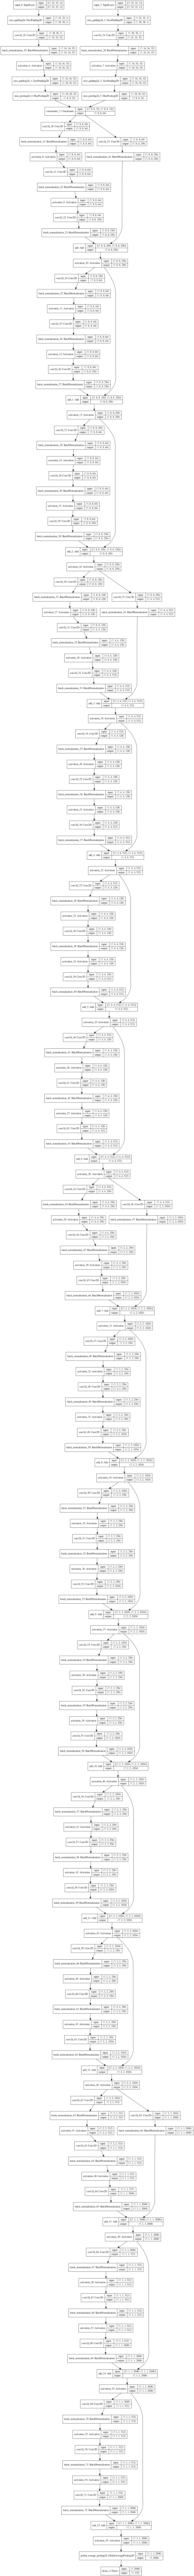

In [18]:
from tensorflow.keras import backend, regularizers, models
L2_WEIGHT_DECAY = 0.01
BATCH_NORM_DECAY = 0.99
BATCH_NORM_EPSILON = 0.001

def identity_block(input_tensor, kernel_size, filters):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
    """
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
 
    x = layers.Conv2D(filters1, (1, 1), use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(input_tensor)
 
    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)
    x = layers.Activation('relu')(x)
 
    x = layers.Conv2D(filters2, kernel_size,
                      padding='same', use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(x)
 
    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)
 
    x = layers.Activation('relu')(x)
 
    x = layers.Conv2D(filters3, (1, 1), use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(x)
 
    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)
 
    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3,
    the second conv layer at main path is with strides=(2, 2)
    And the shortcut should have strides=(2, 2) as well
    """
 
    filters1, filters2, filters3 = filters
 
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
 
    x = layers.Conv2D(filters1, (1, 1), use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)
    x = layers.Activation('relu')(x)
 
 
    x = layers.Conv2D(filters2, kernel_size, strides=strides, padding='same',
                      use_bias=False, kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(x)
    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)
    x = layers.Activation('relu')(x)
 
    x = layers.Conv2D(filters3, (1, 1), use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(x)
    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)
 
    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides, use_bias=False,
                             kernel_initializer='he_normal',
                             kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(input_tensor)
    shortcut = layers.BatchNormalization(axis=bn_axis,
                                         momentum=BATCH_NORM_DECAY,
                                         epsilon=BATCH_NORM_EPSILON)(shortcut)
 
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def resnet50(num_classes, input_shape):
    img_input = layers.Input(shape=input_shape)
    inputA = Input(shape=input_shape)
    inputB = Input(shape=input_shape)
 
    if backend.image_data_format() == 'channels_first':
        x1 = layers.Lambda(lambda x: backend.permute_dimensions(x, (0, 3, 1, 2)),name='transpose')(inputA)
        bn_axis = 1
    else:  # channels_last
        x1 = inputA
        bn_axis = 3
    # Conv1 (7x7,64,stride=2)
    x1 = layers.ZeroPadding2D(padding=(3, 3))(x1)
    x1 = layers.Conv2D(32, (7, 7),
                      strides=(2, 2),
                      padding='valid', use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(x1)
    x1 = layers.BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x1)
    x1 = layers.Activation('relu')(x1)
    x1 = layers.ZeroPadding2D(padding=(1, 1))(x1)
 
    # 3x3 max pool,stride=2
    x1 = layers.MaxPooling2D((3, 3), strides=(2, 2))(x1)
     
    if backend.image_data_format() == 'channels_first':
        x2 = layers.Lambda(lambda x: backend.permute_dimensions(x, (0, 3, 1, 2)),name='transpose')(inputB)
        bn_axis = 1
    else:  # channels_last
        x2 = inputB
        bn_axis = 3
    # Conv1 (7x7,64,stride=2)
    x2 = layers.ZeroPadding2D(padding=(3, 3))(x2)
    x2 = layers.Conv2D(32, (7, 7),
                      strides=(2, 2),
                      padding='valid', use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(x2)
    x2 = layers.BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x2)
    x2 = layers.Activation('relu')(x2)
    x2 = layers.ZeroPadding2D(padding=(1, 1))(x2)
 
    # 3x3 max pool,stride=2
    x2 = layers.MaxPooling2D((3, 3), strides=(2, 2))(x2)
    
    
    combined = concatenate([x1, x2])

    # Conv2_x
    # 1×1, 64
    # 3×3, 64
    # 1×1, 256
 
    x = conv_block(combined, 3, [64, 64, 256], strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256])
    x = identity_block(x, 3, [64, 64, 256])
 
    # Conv3_x
    #
    # 1×1, 128
    # 3×3, 128
    # 1×1, 512
 
    x = conv_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])
 
    # Conv4_x
    # 1×1, 256
    # 3×3, 256
    # 1×1, 1024
    x = conv_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
 
    # 1×1, 512
    # 3×3, 512
    # 1×1, 2048
    x = conv_block(x, 3, [512, 512, 2048])
    x = identity_block(x, 3, [512, 512, 2048])
    x = identity_block(x, 3, [512, 512, 2048])
 
    # average pool, 1000-d fc, softmax
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(
        num_classes, activation='softmax',
        kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY),
        bias_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(x)
    # Create model.
    return models.Model([inputA,inputB], x, name='resnet50')

resnet50 = resnet50(132,(32,32,1))
tf.keras.utils.plot_model(resnet50, show_shapes=True, dpi=64)

In [ ]:
resnet50.compile(optimizer=keras.optimizers.Adam() ,  # Optimizer
              # Loss function to minimize
              loss=keras.losses.CosineSimilarity(),
              # List of metrics to monitor
              metrics=['accuracy'])
resnet50.fit(train_dataset, epochs=30, steps_per_epoch = 1000, validation_steps = 200, validation_data=test_dataset)

In [ ]:
inputA = Input(shape=(32,32,1))
inputB = Input(shape=(32,32,1))

filters = (32, 64)
x=inputA
y=inputB
chanDim = -1
# define the model input
# loop over the number of filters
x = Conv2D(16, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization(axis=chanDim)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Model(inputs=inputA, outputs=x)
y = Conv2D(16, (3, 3), padding="same")(y)
y = Activation("relu")(y)
y = BatchNormalization(axis=chanDim)(y)
y = MaxPooling2D(pool_size=(2, 2))(y)
y = Model(inputs=inputB, outputs=y)

combined = concatenate([x.output, y.output])
for (i, f) in enumerate(filters):
    # if this is the first CONV layer then set the input
    # appropriately
    # CONV => RELU => BN => POOL
    if i == 0:
        first = Conv2D(f, (3, 3), padding="same")(combined)
    else :
        first = Conv2D(f, (3, 3), padding="same")(z)

    z = Activation("relu")(first)
    z = BatchNormalization(axis=chanDim)(z)
    z = MaxPooling2D(pool_size=(2, 2))(z)

# flatten the volume, then FC => RELU => BN => DROPOUT
z = Flatten()(z)
z = Dense(512)(z)
z = Activation("relu")(z)
z = BatchNormalization(axis=chanDim)(z)
z = Dropout(0.5)(z)
# apply another FC layer, this one to match the number of nodes
# coming out of the MLP
z = Dense(132)(z)
z = Activation("relu")(z)
model = Model([x.input, y.input], z)
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
model.compile(optimizer=keras.optimizers.Adam() ,  # Optimizer
              # Loss function to minimize
              loss=keras.losses.CosineSimilarity(),
              # List of metrics to monitor
              metrics=['accuracy'])
model.fit(train_dataset, epochs=30, steps_per_epoch = 1000, validation_steps = 200, validation_data=test_dataset)

In [ ]:
print(training_path)
for file in os.listdir(training_path):
    print('\n',file)
    with open(os.path.join(training_path, file)) as f:
        load = json.load(f)
    preprocess(load, "CORNER")
    result = model((tf.expand_dims(tf.expand_dims(load["train"][0]["input"], -1),0), tf.expand_dims(tf.expand_dims(load["train"][0]["output"], -1),0)))
    print([total_skills[i] for i in np.nonzero(result)[1]],'\n', sorted(skill_series[file]))

### 2n model define

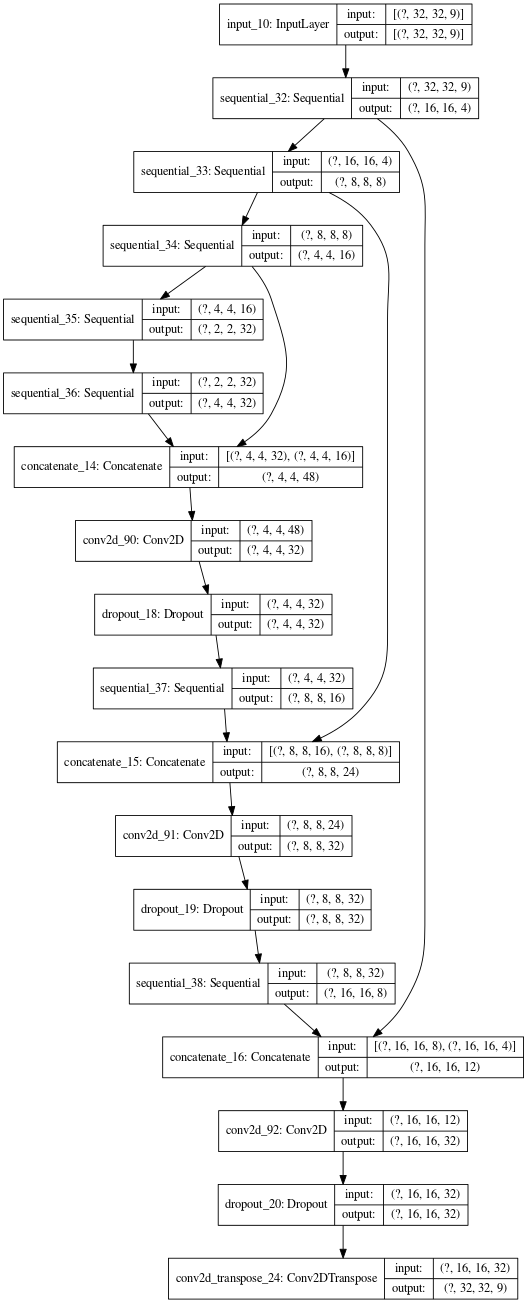

In [33]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result
def Generator():
  OUTPUT_CHANNELS = 9
  inputs = tf.keras.layers.Input(shape=[32,32,9])

  down_stack = [
    downsample(4, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(8, 4), # (bs, 64, 64, 128)
    downsample(16, 4), # (bs, 32, 32, 256)
    downsample(32, 4), # (bs, 16, 16, 512)
  ]

  up_stack = [
    upsample(32, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(16, 4), # (bs, 16, 16, 1024)
    upsample(8, 4), # (bs, 32, 32, 512)
    upsample(4, 4), # (bs, 64, 64, 256)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])
    x = tf.keras.layers.Conv2D(32,(1,1),padding='same')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

### Data prep

3


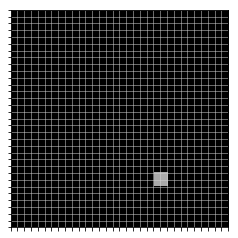

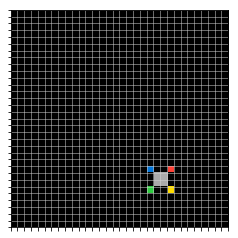

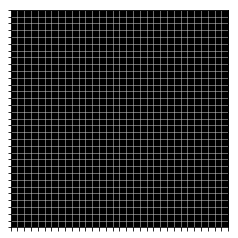

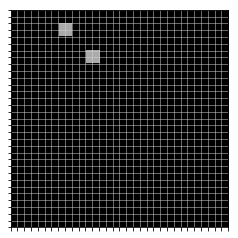

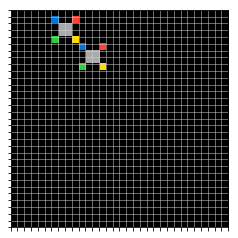

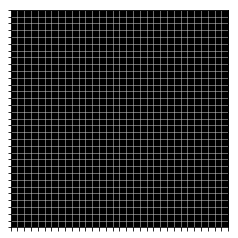

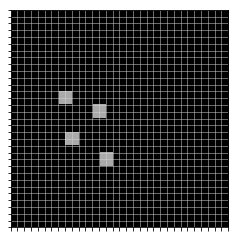

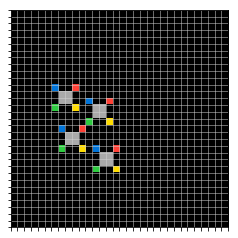

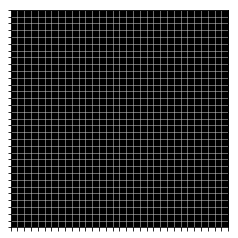

In [36]:
LOGIC_TO_LOAD = [4]
for LOGIC in LOGIC_TO_LOAD:
    print(len(load_task_with_logic("pattern_expansion")[LOGIC]["train"]))
    for task in load_task_with_logic("pattern_expansion")[LOGIC]["train"]:
        to_plot = preprocess_in_out(task, 'CORNER',True)
        gen_output = generator(tf.expand_dims(tf.one_hot(np.array(to_plot["input"], dtype=np.int64),9),0), training=False)
        plot(to_plot["input"])
        plot(to_plot["output"])
        plot(tf.math.argmax(gen_output[0,...],axis=-1))
        #print([gen_output[0][i] for i in range(len(tf.math.argmax(gen_output,axis=-1)[0]))])


In [34]:
input_train = []
output_train = []
for LOGIC in LOGIC_TO_LOAD:
    for task in load_task_with_logic("pattern_expansion")[LOGIC]["train"]:
        for i in range(100):
            # data augment 20 times
            preprocessed_task_train = preprocess_in_out(task,"CORNER", True)
            input_train.append(tf.one_hot(np.array(preprocessed_task_train["input"], dtype=np.int64),9))
            output_train.append(tf.one_hot(np.array(preprocessed_task_train["output"], dtype=np.int64),9))
print(len(input_train), len(output_train))
input_test = []
output_test = []
for LOGIC in LOGIC_TO_LOAD:
    for task in load_task_with_logic("pattern_expansion")[LOGIC]["test"]:
        for i in range(100):
            # data augment 20 times
            preprocessed_task_test = preprocess_in_out(task,"CORNER", True)
            input_test.append(tf.one_hot(np.array(preprocessed_task_test["input"], dtype=np.int64),9))
            output_test.append(tf.one_hot(np.array(preprocessed_task_test["output"], dtype=np.int64),9))

train_input_dataset = tf.data.Dataset.from_tensor_slices(input_train)
#train_input_dataset = train_input_dataset.map(lambda x: (tf.math.divide(x,9)))
#train_input_dataset = train_input_dataset.map(lambda x : (tf.expand_dims(x,-1)))

train_output_dataset = tf.data.Dataset.from_tensor_slices(output_train)
#train_output_dataset = train_output_dataset.map(lambda x: (tf.math.divide(x,9)))
#train_output_dataset = train_output_dataset.map(lambda x : (tf.expand_dims(x,-1)))

train_dataset = tf.data.Dataset.zip((train_input_dataset, train_output_dataset)).batch(5).repeat()

test_input_dataset = tf.data.Dataset.from_tensor_slices(input_test)
#test_input_dataset = test_input_dataset.map(lambda x: (tf.math.divide(x,9)))
#test_input_dataset = test_input_dataset.map(lambda x : (tf.expand_dims(x,-1)))

test_output_dataset = tf.data.Dataset.from_tensor_slices(output_test)
#test_output_dataset = test_output_dataset.map(lambda x: (tf.math.divide(x,9)))
#test_output_dataset = test_output_dataset.map(lambda x : (tf.expand_dims(x,-1)))

test_dataset = tf.data.Dataset.zip((test_input_dataset, test_output_dataset)).batch(5).repeat()

generator.compile(optimizer=keras.optimizers.Adam() ,  # Optimizer
              # Loss function to minimize
              loss=keras.losses.CosineSimilarity(),
              # List of metrics to monitor
              metrics=['accuracy'])

300 300


In [35]:
generator.fit(train_dataset, epochs=5, steps_per_epoch = 2000, validation_steps = 500, validation_data=test_dataset)

Train for 2000 steps, validate for 500 steps
Epoch 1/5
2000/2000 [==============================] - 21s 10ms/step - loss: -0.9646 - accuracy: 0.9803 - val_loss: -0.9533 - val_accuracy: 0.9531
Epoch 2/5
2000/2000 [==============================] - 19s 9ms/step - loss: -0.9801 - accuracy: 0.9818 - val_loss: -0.9534 - val_accuracy: 0.9531
Epoch 3/5
 108/2000 [>.............................] - ETA: 16s - loss: -0.9804 - accuracy: 0.9815

KeyboardInterrupt: 

In [ ]:
for elemn in train_dataset:
    [plot(inner) for inner in [tf.squeeze(elem, 0) for elem in tf.argmax(elemn,axis=-1)]]
    break